Welcome! 🪰💻 This is meant to be a tutorial-like notebook to introduce you to the model. It's a work in progress but hopefully will help to get a handle of the basics.

*First, imports and plotting defaults. **For this tutorial, the lightweight single simulations will just run on CPU, unless you choose to modify this block.***

In [1]:
# Import packages and set environment variables
%load_ext autoreload
%autoreload 2

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import os
import jax
jax.config.update('jax_default_device', jax.devices('cpu')[0]) # MAKES CPU THE DEFAULT FOR RUNNING JAX
import sparse

from pathlib import Path
from natsort import natsorted
# from src.utils import io_dict_to_hdf5 as ioh5
from src.utils.sim_utils import *
from src.utils.plot_utils import *
from src.simulation.vnc_sim import *
from src.utils.path_utils import *
from omegaconf import OmegaConf
from tqdm.auto import tqdm
from src.utils.path_utils import register_custom_resolvers
register_custom_resolvers()

Using diffeqsolve-based neural simulation (original)


In [2]:
# Plotting defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (3,1.5)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["figure.dpi"] = 200

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"
lightInhColor = "#00acd6"
connColormap = sns.blend_palette([inhColor,lightInhColor,"white",lightExcColor,excColor],as_cmap=True)

# Specify or create paths

If you have not yet created a YAML file in `configs/paths` that is specific to your local filesystem, you can bypass that step for now and run the first cell below, which will generate a sort of placeholder/starting point. Otherwise, you can uncomment run the second cell with the name of the YAML file you want to use as `pathsName`. **In this tutorial, no simulation data will be saved!**

In [3]:
experimentName = "DNg100_Stim"
pathsName = "starting-paths"

cwd = os.path.dirname(os.getcwd())
pathsDict = {"cwd_dir": cwd,                                # current working directory
         "base_dir": f"{cwd}/data/simulation output",       # directory within which you would want all of your simulations to save (you won't create the dir or save anything this tutorial, so it doesn't matter what it is!)
         "save_dir": "${paths.base_dir}/run_id=${run_id}",  # where you want outputs of individual runs to save - folder within the base directory specified by the run_id
         "log_dir":  "${paths.save_dir}/logs/",             # logs, ckpts, and figures contain specific components of the outputs
         "ckpt_dir": "${paths.save_dir}/ckpt/",
         "fig_dir":  "${paths.save_dir}/figures/",
         "data_dir": f"{cwd}/data/"
    }

with open(f"{cwd}/configs/paths/{pathsName}.yaml","w") as file:
    yaml.dump(pathsDict, file)

In [4]:
# experimentName = "DNg100_Stim"
# pathsName = "walle-smpuglie"

# Load in the simulation parameters from your config

In [5]:
config = create_fresh_config_with_paths(experiment=experimentName,paths_template=pathsName,config_dir="../../configs")
for key in config.paths.keys():
    if (key != 'user'):
        config.paths[key] = Path(config.paths[key])
        # config.paths[key].mkdir(parents=True, exist_ok=True) # uncomment to have it actually create these directories -- don't need to for tutorial

🔄 Creating fresh config for experiment 'DNg100_Stim' with paths template 'starting-paths'
✅ Created fresh config:
   Experiment: DNg100_Stim
   Version: debug
   Paths template: starting-paths
   Save dir: /Users/sarahpugliese/Documents/python/bdn2cpg/data/simulation output/run_id=Testing


In [6]:
config.experiment.n_replicates = 1  # the amount of sims to set up
config.experiment.seed = 24         # random seed for setting parameters. feel free to change to see how it affects the output!

wTable = load_wTable(config.experiment.dfPath)
neuronParams = prepare_neuron_params(config, wTable)
nNeurons = len(neuronParams.W)

simNo = 0                           # which simulation to run (0-n_replicates)

Created 1 stimulus configurations


*Optional: Increase the error tolerances to run the simulation faster for this tutorial.* There's a tradeoff between runtime and numerical error. Default values are `r_tol=2e-06` and `a_tol=5e-09`.

In [7]:
config.sim.rtol = 1e-04
config.sim.atol = 1e-07

Prepare parameters for the simulation

In [8]:
simParams = prepare_sim_params(config,1,nNeurons)

Make quick plots to show the network setup. First, plot a randomly-chosen subset of $\mathbf{W}$. Then, plot the distribution of biophysical parameters across the entire network for this replicate:

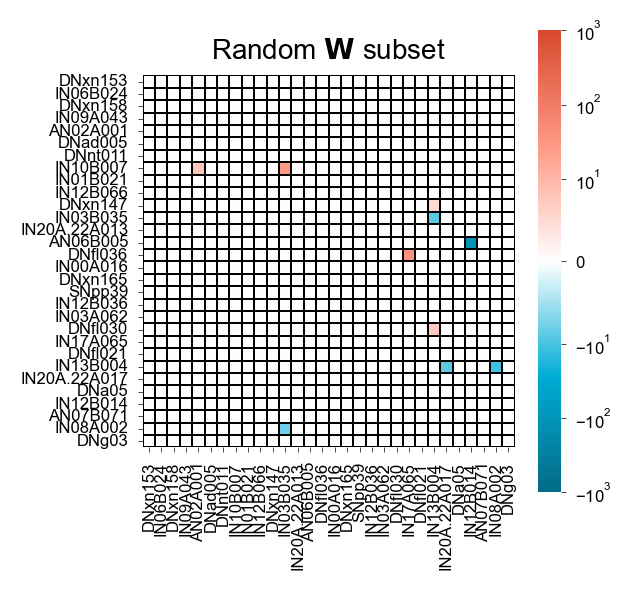

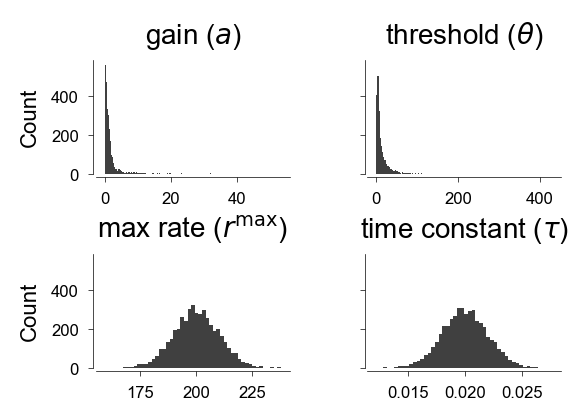

In [9]:
# Plot a randomly-chosen subset of the weight matrix
randIdxs = np.random.randint(0,4604,30)
plt.figure(figsize=(3,3))
plt.title(r"Random $\mathbf{W}$ subset",fontsize=TITLE_SIZE)
sns.heatmap(neuronParams.W[np.ix_(randIdxs,randIdxs)],xticklabels=wTable.loc[randIdxs,"type"],yticklabels=wTable.loc[randIdxs,"type"],linecolor="k",linewidths=0.0625,
            cmap=connColormap,square=True,norm=colors.SymLogNorm(10,vmin=-1000,vmax=1000))
plt.show()

# Plot the biophysical parameters for asingle simulation
fig,ax = plt.subplots(2,2,figsize=(3,2),sharey=True,gridspec_kw={"hspace":0.7,"wspace":0.4})
sns.histplot(neuronParams.a[simNo],color="k",edgecolor="None",ax=ax[0][0],)
ax[0][0].set_title(r"gain ($a$)",fontsize=TITLE_SIZE)
sns.histplot(neuronParams.threshold[simNo],color="k",edgecolor="None",ax=ax[0][1],)
ax[0][1].set_title(r"threshold ($\theta$)",fontsize=TITLE_SIZE)
sns.histplot(neuronParams.fr_cap[simNo],color="k",edgecolor="None",ax=ax[1][0],)
ax[1][0].set_title(r"max rate ($r^{\max}$)",fontsize=TITLE_SIZE)
sns.histplot(neuronParams.tau[simNo],color="k",edgecolor="None",ax=ax[1][1],)
ax[1][1].set_title(r"time constant ($\tau$)",fontsize=TITLE_SIZE)
sns.despine(offset=1)

plt.show()

# Run the simulation, then plot the activity

In [10]:
def run_single_simulation_helper(W: jnp.ndarray, neuronParams: NeuronParams, simParams: SimParams, key: jnp.ndarray) -> jnp.ndarray: # helper function
    """runs simulation given W, neuronParams, simParams, and a random key"""
    
    W_masked = W * neuronParams.W_mask
    W_reweighted = reweight_connectivity(W_masked, simParams.exc_multiplier, simParams.inh_multiplier)
    R = run_single_simulation(
        W_reweighted,
        neuronParams.tau,
        neuronParams.a, 
        neuronParams.threshold,
        neuronParams.fr_cap,
        neuronParams.input_currents[simNo],
        simParams.noise_stdv,
        simParams.t_axis,
        simParams.T,
        simParams.dt,
        simParams.pulse_start,
        simParams.pulse_end,
        simParams.r_tol,
        simParams.a_tol,
        key
    )
    return R

Run the simulation

In [11]:
neuronParams_single = jax.tree.map(lambda x: x[simNo], neuronParams) # params for this simulation in particular
key = jax.random.PRNGKey(0) # random key

# Run the simulation and return R = matrix of firing rates r for each neuron over time)
startTime = time.time() # time the simulation
R = run_single_simulation_helper(neuronParams.W, neuronParams_single, simParams, key)
R.block_until_ready()
endTime = time.time()

print('Final results (R) shape:', R.shape)
print('Simulation time (s):', endTime - startTime)

Final results (R) shape: (4604, 2001)
Simulation time (s): 18.698487758636475


Plot motor neuron activity

/Users/sarahpugliese/Documents/python/bdn2cpg/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


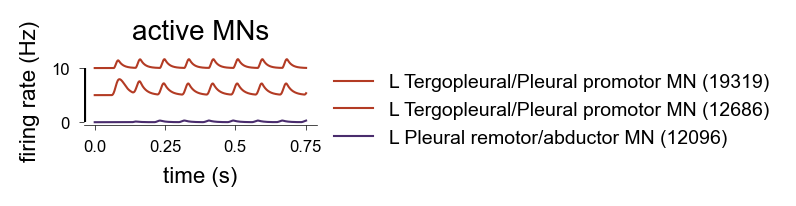

In [12]:
plt.figure()

spacer = 5
scalebar = 10
tAxisLimit = .75 # only plot up to this time point

mnData = sort_motor_modules(wTable.loc[wTable["class"]=="motor neuron"])
tArrayLimit = int(tAxisLimit/simParams.dt)
ax = plot_R_traces_stacked_by_module(np.array(R)[:,:tArrayLimit],mnData,activeOnly=True,space=spacer)
add_tAxis(ax,tAxisLimit,3.00001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,scalebar,"k")
plt.yticks([0,scalebar])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
fig = plt.gcf()
ax.grid(False)
plt.xlabel("time (s)")


fig.set_figwidth(1.5)
fig.set_figheight(0.15*len(get_active_data(np.array(R)[mnData.index],mnData)))
plt.title("active MNs",fontsize=TITLE_SIZE)

plt.show()

Maybe you're curious to plot the left and right DNg100 activity. You can just search the `wTable` for the indices of those neurons and plot the corresponding row of `R`.

In [13]:
display(wTable.loc[wTable["type"]=="DNg100"])

,bodyId,type,class,subclass,hemilineage,size,predictedNt,predictedNtProb,ntAcetylcholineProb,ntGabaProb,ntGlutamateProb,somaSide,motor module,step contribution
31,10093,DNg100,descending neuron,xl,NaN,7124816452,acetylcholine,0.957519,0.957519,0.013868,0.025821,NaN,NaN,NaN
132,10339,DNg100,descending neuron,xl,NaN,7435937069,acetylcholine,0.941600,0.941600,0.016269,0.037436,NaN,NaN,NaN


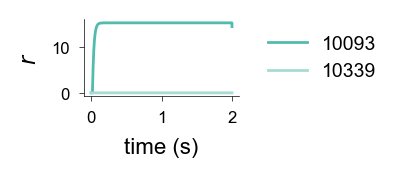

In [14]:
plt.figure(figsize=(1,0.5))
plt.plot(simParams.t_axis, R[31], label=wTable.loc[31,"bodyId"],
         color=dnColor, linewidth=1)
plt.plot(simParams.t_axis, R[132],  label=wTable.loc[132,"bodyId"],
         color=lightDnColor, linewidth=1)
plt.legend(loc="right",bbox_to_anchor=[2,0.5],edgecolor="None")
plt.xlabel("time (s)")
plt.ylabel(r"$r$")
plt.show()

As expected, the left DNg100 (10093) is tonically active and the right DNg100 (10339) is silent.

# Modify the simulation
Here are a few examples that show how the simulation configuration you loaded can be quickly modified from within a Jupyter notebook.

### **Example 1:** Silence the I1 and I2 neurons during the same DNg100 L activation experiment

In [15]:
newConfig = config.copy()
newConfig.experiment.removeNeurons = [wTable.loc[(wTable["type"].isin(["IN19A007","IN16B036"]))&(wTable["somaSide"]=="LHS")].index.tolist()] # indices of these cell types on the left hand side

Build new parameters from modified config:

In [16]:
wTable = load_wTable(newConfig.experiment.dfPath)
neuronParams = prepare_neuron_params(newConfig, wTable)
nNeurons = len(neuronParams.W)
simParams = prepare_sim_params(newConfig,1,nNeurons)

Created 1 stimulus configurations
Initial removal of neurons at indices: [[86, 1167]]


Run and plot:

In [17]:
neuronParams_single = jax.tree.map(lambda x: x[simNo], neuronParams) # params for this simulation in particular
key = jax.random.PRNGKey(0) # random key

# Run the simulation and return newR = matrix of firing rates r for each neuron over time)
startTime = time.time() # time the simulation
newR = run_single_simulation_helper(neuronParams.W, neuronParams_single, simParams, key)
newR.block_until_ready()
endTime = time.time()

print('Final results (newR) shape:', newR.shape)
print('Simulation time (s):', endTime - startTime)

Final results (newR) shape: (4604, 2001)
Simulation time (s): 16.510886907577515


/Users/sarahpugliese/Documents/python/bdn2cpg/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


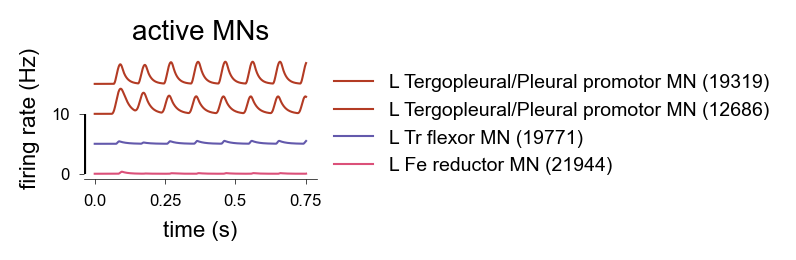

In [18]:
plt.figure()
spacer = 5
scalebar = 10
tAxisLimit = .75

mnData = sort_motor_modules(wTable.loc[wTable["class"]=="motor neuron"])
tArrayLimit = int(tAxisLimit/simParams.dt)
ax = plot_R_traces_stacked_by_module(np.array(newR)[:,:tArrayLimit],mnData,activeOnly=True,space=spacer)
add_tAxis(ax,tAxisLimit,3.00001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,scalebar,"k")
plt.yticks([0,scalebar])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
fig = plt.gcf()
ax.grid(False)
plt.xlabel("time (s)")


fig.set_figwidth(1.5)
fig.set_figheight(0.2*len(get_active_data(np.array(newR)[mnData.index],mnData)))
plt.title("active MNs",fontsize=TITLE_SIZE)

plt.show()

As you can see, the oscillating activity is still intact when these neurons are both silenced, but the neurons you recruit are slightly different.

### **Example 2:** Decrease the mean time constant during the same DNg100 L activation experiment

In [19]:
newConfig = config.copy()
newConfig.neuron_params.tauMean = 0.015    # 15 ms; default is 20 ms

Build new parameters from modified config:

In [20]:
wTable = load_wTable(newConfig.experiment.dfPath)
neuronParams = prepare_neuron_params(newConfig, wTable)
nNeurons = len(neuronParams.W)
simParams = prepare_sim_params(newConfig,1,nNeurons)

Created 1 stimulus configurations


Run and plot:

In [21]:
neuronParams_single = jax.tree.map(lambda x: x[simNo], neuronParams) # params for this simulation in particular
key = jax.random.PRNGKey(0) # random key

# Run the simulation and return newR = matrix of firing rates r for each neuron over time)
startTime = time.time() # time the simulation
newR = run_single_simulation_helper(neuronParams.W, neuronParams_single, simParams, key)
newR.block_until_ready()
endTime = time.time()

print('Final results (newR) shape:', newR.shape)
print('Simulation time (s):', endTime - startTime)

Final results (newR) shape: (4604, 2001)
Simulation time (s): 23.109313011169434


/Users/sarahpugliese/Documents/python/bdn2cpg/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


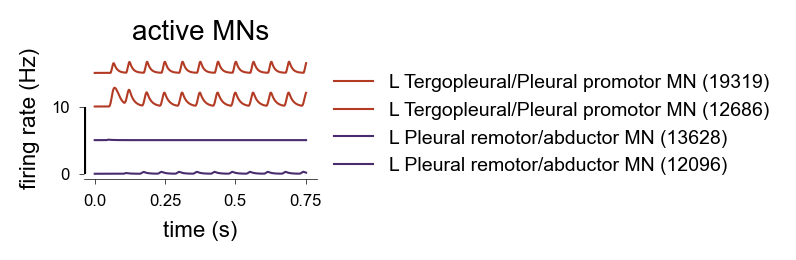

In [22]:
plt.figure()
spacer = 5
scalebar = 10
tAxisLimit = .75

mnData = sort_motor_modules(wTable.loc[wTable["class"]=="motor neuron"])
tArrayLimit = int(tAxisLimit/simParams.dt)
ax = plot_R_traces_stacked_by_module(np.array(newR)[:,:tArrayLimit],mnData,activeOnly=True,space=spacer)
add_tAxis(ax,tAxisLimit,3.00001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,scalebar,"k")
plt.yticks([0,scalebar])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
fig = plt.gcf()
ax.grid(False)
plt.xlabel("time (s)")


fig.set_figwidth(1.5)
fig.set_figheight(0.2*len(get_active_data(np.array(newR)[mnData.index],mnData)))
plt.title("active MNs",fontsize=TITLE_SIZE)

plt.show()

### **Example 3:** Maintain the network setup, but activate one of the DNa02 turning neurons instead of DNg100

DNa02 is a descending neuron that drives turning towards the ipsilateral side during walking ([Rayshubiskiy et al., 2025](https://doi.org/10.7554/eLife.102230.3)).

In [23]:
display(wTable.loc[wTable["type"]=="DNa02"])

,bodyId,type,class,subclass,hemilineage,size,predictedNt,predictedNtProb,ntAcetylcholineProb,ntGabaProb,ntGlutamateProb,somaSide,motor module,step contribution
46,10118,DNa02,descending neuron,xl,NaN,6179155956,acetylcholine,0.870474,0.870474,0.022529,0.100239,NaN,NaN,NaN
51,10126,DNa02,descending neuron,xl,NaN,6459395030,acetylcholine,0.885044,0.885044,0.020543,0.090257,NaN,NaN,NaN


In [24]:
newConfig = config.copy()
newConfig.experiment.stimNeurons = [wTable.loc[wTable["bodyId"]==10126].index.tolist()] # activate the L DNa02 neuron (bodyId 10126)
newConfig.experiment.stimI = [[300]] # change the stimulus strength to 300; default is 250

Build new parameters from modified config:

In [25]:
wTable = load_wTable(newConfig.experiment.dfPath)
neuronParams = prepare_neuron_params(newConfig, wTable)
nNeurons = len(neuronParams.W)
simParams = prepare_sim_params(newConfig,1,nNeurons)

Created 1 stimulus configurations


Run and plot:

In [26]:
neuronParams_single = jax.tree.map(lambda x: x[simNo], neuronParams) # params for this simulation in particular
key = jax.random.PRNGKey(0) # random key

# Run the simulation and return newR = matrix of firing rates r for each neuron over time)
startTime = time.time() # time the simulation
newR = run_single_simulation_helper(neuronParams.W, neuronParams_single, simParams, key)
newR.block_until_ready()
endTime = time.time()

print('Final results (newR) shape:', newR.shape)
print('Simulation time (s):', endTime - startTime)

Final results (newR) shape: (4604, 2001)
Simulation time (s): 3.128790855407715


/Users/sarahpugliese/Documents/python/bdn2cpg/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


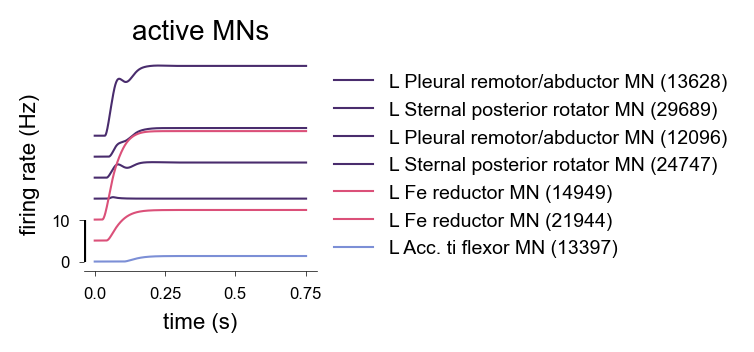

In [27]:
plt.figure()
spacer = 5
scalebar = 10
tAxisLimit = .75

mnData = sort_motor_modules(wTable.loc[wTable["class"]=="motor neuron"])
tArrayLimit = int(tAxisLimit/simParams.dt)
ax = plot_R_traces_stacked_by_module(np.array(newR)[:,:tArrayLimit],mnData,activeOnly=True,space=spacer)
add_tAxis(ax,tAxisLimit,3.00001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,scalebar,"k")
plt.yticks([0,scalebar])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
fig = plt.gcf()
ax.grid(False)
plt.xlabel("time (s)")


fig.set_figwidth(1.5)
fig.set_figheight(0.2*len(get_active_data(np.array(newR)[mnData.index],mnData)))
plt.title("active MNs",fontsize=TITLE_SIZE)

plt.show()

This neuron seems likely to recruit the coxa remotor, coxa posterior rotator, and femur reductor muscles. If you want, you can also try activating the other DNa02 neuron to see what the MN output looks like.

# Going forward
This is a quick and easy way to get a sense for one-off simulations, especially if you're most comfortable working in a notebook. You can add your own W matrices and data tables to your `data_dir` as well, and create new default `experiment` YAML files similar to `DNg100_Stim.yaml` to test them out. 

However, to run simulations at scale and save/load the rate matrix and config files according to the built-in structure, you should take full advantage of the Hydra setup to run and modify simulations from the command line. README.md and Basic_Usage.ipynb will give a starting point! 